# Tarea 2 : Seminario de Estadística (EPG 3341) 
### Camilo González Rojas
##### 18 de Mayo

**Nota**: La tarea fue realizada utilizando macOS por lo que los directorios se escriben utilizando `/`,  <br/> en Window se utiliza `\` pero admite `/`, en cualquier caso, si se presenta algún error con la lectura, probar cambiar `/` por `\`.  

### Carga de Librerías

Usaremos la libreria `os` para que el método que describe los datos pueda crear la carpeta `Analisis` en la raíz. Esto fue autorizado por el profesor. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

### Separación de Datos

En este paso dividimos nuestros datos en un archivo de entrenamiento y otro de prueba.   
Se generan dos archivos en la ruta especificada uno con el 70% de los datos y otro con el 30%.  
Notemos que en el enunciado no pide que este paso sea incluido como método de la clase.
  

In [2]:
def separacion_de_datos(ruta_archivo_original, ruta_archivos_separados):
    try:
        data = pd.read_csv(ruta_archivo_original)
        split = train_test_split(data.index, test_size = 0.3)
        data_train = data.loc[split[0]]
        data_test = data.loc[split[1]]
        del data_train['Unnamed: 0']
        del data_test['Unnamed: 0']
        data_train.to_csv(ruta_archivos_separados + '/data_train.csv', index = False)
        data_test.to_csv(ruta_archivos_separados + '/data_test.csv', index = False)
        msj = 'Los datos fueron separados y guardados correctamente.'
        
    except:
        msj = 'Los datos no fueron guardados, revise su ruta de carga y de guardado por favor.'
        
    return print(msj)

Dejaré escrita mi ruta como ejemplo.

In [3]:
ruta_cargar = '/Users/camilo/Google Drive/Universidad/Magíster en Estadística/2020-1/Minería de Datos con Python/Tareas/Tarea 2 2020/Entrega/loan.csv'
ruta_guardar = '/Users/camilo/Google Drive/Universidad/Magíster en Estadística/2020-1/Minería de Datos con Python/Tareas/Tarea 2 2020/Entrega/Datos T-T'
separacion_de_datos(ruta_cargar, ruta_guardar)

Los datos fueron separados y guardados correctamente.


### Definición de la Clase

In [2]:
# Paso 1
class Clasificador:

    def __init__(self, ruta_datos, porcentaje_na):
        self.ruta_datos = ruta_datos
        self.base_de_datos = []
        self.porcentaje_na = porcentaje_na
        
# Paso 2
    def carga_de_datos(self):
        try:
            datos = pd.read_csv(self.ruta_datos)
            for i in range(0, datos.shape[1]):
                porcentaje = (datos.iloc[:,[i]].isna().sum()*100 / datos.shape[0])[0]                   # Calculo de Porcentaje de NA
                if porcentaje > self.porcentaje_na:                                                     # Se distingue si el porcentaje de NA es mayor a p
                    if datos.dtypes[i] != object:                                                       # Se distingue entre data categorica o numérica
                        datos.iloc[:,[i]] = datos.iloc[:,[i]].fillna(-1)                                # Se le asigna -1 si es numérica
                    elif datos.dtypes[i] == object:                                                     # Se distingue entre data categorica o numérica
                        datos.iloc[:,[i]] = datos.iloc[:,[i]].fillna('categoria_aux')                   # Se asigna 'categoria_aux' 
                else:
                    if datos.dtypes[i] != object:                                                       # Igual que lo anterior para % de NA menor o igual a 
                        datos.iloc[:,[i]] = datos.iloc[:,[i]].fillna(datos.iloc[:,[i]].median())        # Se usa la mediana o la moda según corresponda               
                    elif datos.dtypes[i] == object:
                        datos.iloc[:,[i]] = datos.iloc[:,[i]].fillna(datos.iloc[:,[i]].mode().loc[0])
            self.base_de_datos = datos
            self.base_de_datos.rename(columns={
                'NumberOfTime30-59DaysPastDueNotWorse' : 'NumberOfTime3059DaysPastDueNotWorse',        # Se cambian los nombres con '-' 
                'NumberOfTime60-89DaysPastDueNotWorse' : 'NumberOfTime6089DaysPastDueNotWorse'         # debido a problemas con querys y ajustes
                    }, inplace=True)
            return self.base_de_datos
        
        except:
            msj = 'Los datos no fueron cargados, revise su ruta por favor.'
            return print(msj)
    
    
# Paso 3
    def analisis(self):
        datos = self.base_de_datos
        skewness = []
        for i in range(0, datos.shape[1]):                                                              # Calculo de la asimetría
            columna = datos.iloc[:,[i]]                                                                 # El calculo distingue entre variables 
            if datos.dtypes[i] != object:                                                               # numéricas y continuas
                numerador_sk = (((columna - columna.mean())**3).sum())*(1/len(columna))
                denominador_sk = ((((columna - columna.mean())**2).sum())*(1/(len(columna)-1)))**(3/2)
                skewness.append((numerador_sk/denominador_sk)[0]) 
            else: 
                skewness.append('Categorica - Sin Skewness')
        descripcion = datos.describe(include='all')
        mediana = datos.median()
        df_sk =pd.DataFrame(columns = [''])
        for i in range(0, datos.shape[1]):
            df_sk[datos.columns[i]] = [skewness[i]]
        resumen = (df_sk.append(descripcion)).reset_index()
        resumen.iloc[[0],[0]] = 'skewness'
        resumen = resumen.rename(columns={'index': 'statistic'})
        resumen = resumen.append(mediana, ignore_index=True)
        resumen.at[(resumen.shape[0]-1), 'statistic'] = 'median'                                        # Se crea el resumen con el comando describe y de agrega
        del resumen['']                                                                                 # tanto la asimetría como la mediana
        try:                                                                                            # Se crea o se guarda la carpeta Analisis
            path = os.getcwd()
            os.mkdir(path+'/Analisis')
            resumen.to_csv('Analisis/resumen.csv', index = False)
        except:
            resumen.to_csv('Analisis/resumen.csv', index = False)
        for k in range(0, datos.shape[1]):                                                              # Se crean y se guardan las densidades o
            plt.figure()                                                                                # en su defecto histogramas
            columna_plot = datos.iloc[:,[k]]
            try:
                j = str(k)
                sns.distplot(columna_plot, kde= True)
                plt.savefig('Analisis/plot_variable_'+j+'.png')
                plt.close()
            except: 
                sns.distplot(columna_plot, kde= False)
                plt.savefig('Analisis/plot_variable_'+j+'.png')
                plt.close()        
        return (print('El resumen descriptivo se ha guardado en la carpeta Analisis en la raiz de su proyecto.'),
                print('Se sugiere fuertemente categorizar las variables cuyo gráfico es de color amarillo.'),
                print('Nota: Puede que hayan otras variables que también sea necesario categorizar.'))
    
    
 # Paso 4
    def transformacion(self, max_bins):                                                                            
        desea_transformar = input('¿Desea transformar una variable? y/n:')   
        print('-------------------------------------------------------------')
        while desea_transformar == 'y':
            n_col = input('Ingrese el numero de columna que desea transformar (ej: 7):')
            n_col = int(n_col)
            print('-------------------------------------------------------------')
            print('Las transformaciones disponibles son las siguientes:')
            print('1: log(x)')
            print('2: raiz(x)')
            print('3: 1/x')
            print('4: x**(-2)')
            tipo_transformacion = input('Ingrese el número de la transformación:')
            tipo_transformacion = int(tipo_transformacion)
            try:
                col = self.base_de_datos.iloc[:,[n_col]]
                if tipo_transformacion == 1:
                    self.base_de_datos.iloc[:,[n_col]] = np.log(col + np.abs(np.min(col)) + 1) 
                if tipo_transformacion == 2:
                    self.base_de_datos.iloc[:,[n_col]] = np.sqrt(col + np.abs(np.min(col)))
                if tipo_transformacion == 3:
                    self.base_de_datos.iloc[:,[n_col]] = 1/(col + np.abs(np.min(col)) + 1)
                if tipo_transformacion == 4:
                    self.base_de_datos.iloc[:,[n_col]] = (col + np.abs(np.min(col)) + 1)**-2
            except:
                print('-------------------------------------------------------------')
                print('Hubo un error en la transformación, intente nuevamente.')
            print('-------------------------------------------------------------')
            desea_transformar = input('¿Desea transformar otra variable? y/n:')
        print('-------------------------------------------------------------')
        desea_categorizar = input('¿Desea categorizar una variable? y/n:')
        while desea_categorizar == 'y':
            n_col = input('Ingrese el numero de columna que desea categorizar (ej: 3):')
            n_col = int(n_col)
            col_name = self.base_de_datos.columns[n_col]
            print(col_name)
            if n_col in [3, 7, 8, 9, 10]:
                print('Debido a la naturaleza de la variable el número de bins disponibles')
                print('para que cada categoría tenga 5% de los datos son: ')
                
                if n_col == 3:
                    bins_disp = input('2 y 3, elija una:')
                    bins_disp = int(bins_disp)
                    if bins_disp == 2:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(1,100), '[1,98]')
                        print('Éxito en la categorización.')
                    if bins_disp == 3:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(1, '[1,2)') 
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(2,100), '[2,98]')
                        
                        print('Éxito en la categorización.')
                if n_col == 7:
                    bins_disp = input('2, ingrese 2 si quiere categorizar: ')
                    bins_disp = int(bins_disp)
                    if bins_disp == 2:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(1,100), '[1,98]')
                        print('Éxito en la categorización.')
                        
                if n_col == 8:
                    bins_disp = input('2, 3 y 4, elija una:')
                    bins_disp = int(bins_disp)
                    if bins_disp == 2:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(1,100), '[1,54]')
                        print('Éxito en la categorización.') 
                    if bins_disp == 3:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(1, '[1,2)') 
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(2,100), '[2,54]')
                        print('Éxito en la categorización.')
                    if bins_disp == 4:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(1, '[1,2)') 
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(2, '[2,3)') 
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(3,100), '[3,54]')
                        print('Éxito en la categorización.')
                        
                if n_col == 9:
                    bins_disp = input('2, ingrese 2 si quiere categorizar: ')
                    bins_disp = int(bins_disp)
                    if bins_disp == 2:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(1,100), '[1,98]')
                        print('Éxito en la categorización.')
                             
                if n_col == 10:
                    bins_disp = input('2, 3 y 4, elija una:')
                    bins_disp = int(bins_disp)
                    self.base_de_datos[col_name] = self.base_de_datos[col_name].apply(np.int64)
                    if bins_disp == 2:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(1,100), '[1,20]')
                        print('Éxito en la categorización.') 
                    if bins_disp == 3:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(1, '[1,2)') 
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(2,100), '[2,20]')
                        print('Éxito en la categorización.')
                    if bins_disp == 4:
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(0, '[0,1)')
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(1, '[1,2)') 
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(2, '[2,3)') 
                        self.base_de_datos[col_name] = self.base_de_datos[col_name].replace(range(3,100), '[3,20]')
                        print('Éxito en la categorización.')     
            
            else:
                print('El numero máximo de divisiones ingresado fue: ', max_bins)
                if max_bins <= 20:
                    self.base_de_datos[col_name] = pd.qcut(self.base_de_datos[col_name], max_bins, duplicates = 'drop')
                else: print('El número de bins elegidos no permite una categorización con 5% de datos por cada categoría.')
            print('-------------------------------------------------------------------')
            desea_categorizar = input('¿Desea categorizar otra variable? y/n:')
        print('-------------------------------------------------------------')
        return print('El proceso finalizó correctamente.')
    

# Paso 5
    def relevancia(self): 
        n_col = input('Ingrese el numero de columna que desea conocer el IV e IG (ej: 3):')
        n_col = int(n_col)
        col_name = self.base_de_datos.columns[n_col]
        df_local = self.base_de_datos
        aux = df_local[col_name]
        if self.base_de_datos.dtypes[n_col] == 'int64' or self.base_de_datos.dtypes[n_col] == 'float64':
            df_local[col_name] = pd.qcut(df_local[col_name], 10, duplicates = 'drop')
        else: None
            
        total_unos = self.base_de_datos.iloc[:,[0]].sum()[0]
        total = len(self.base_de_datos.iloc[:,[0]])
        total_ceros = total - total_unos
        entropia = (-total_unos/total)*np.log(total_unos/total) - (total_ceros/total)*np.log(total_ceros/total)
        tabla = df_local.groupby([col_name]).agg({'SeriousDlqin2yrs': [np.count_nonzero, len]})
        tabla = tabla.SeriousDlqin2yrs
        tabla = tabla.assign(count_zeros = lambda x: (x.len - x.count_nonzero))
        tabla = tabla.assign(pc_ceros = lambda x: (x.count_zeros/total_ceros))
        tabla = tabla.assign(pc_unos = lambda x: (x.count_nonzero/total_unos))
        tabla = tabla.assign(WOE = lambda x: (np.log(x.pc_unos / x.pc_ceros)))
        tabla = tabla.assign(IV = lambda x: abs(x.WOE*( x.pc_ceros - x.pc_unos)))
        tabla = tabla.assign(entropy = lambda x: (x.len/total)*((-x.count_nonzero/x.len)*np.log(x.count_nonzero/x.len)
                                                                - (x.count_zeros/x.len)*np.log(x.count_zeros/x.len)))
        iv = tabla.IV.sum()
        ig = entropia - tabla.entropy.sum()
        df_local[col_name] = aux
        print('Information Value: ', iv)
        print('Information Gain: ', ig)
        return None
    
    
#Paso 6
    def ajuste(self, profundidad):
        aux = self.base_de_datos
        df = self.base_de_datos.apply(preprocessing.LabelEncoder().fit_transform)
        X = df.iloc[:,[1,2,3,4,5,6,7,8,9,10]]
        Y = df.iloc[:,[0]]
        self.arbol = tree.DecisionTreeClassifier(max_depth = profundidad)
        self.arbol = self.arbol.fit(X, Y)
        self.base_de_datos = aux
        formula = "SeriousDlqin2yrs ~ RevolvingUtilizationOfUnsecuredLines" 
        formula = formula + " +  age + C(NumberOfTime3059DaysPastDueNotWorse) + DebtRatio"
        formula = formula + " + NumberOfOpenCreditLinesAndLoans + C(NumberOfTimes90DaysLate)"
        formula = formula + " + C(NumberRealEstateLoansOrLines) + C(NumberOfTime6089DaysPastDueNotWorse)"
        formula = formula + " + C(NumberOfDependents)"
        self.logistica = smf.logit(formula = formula, data = self.base_de_datos)
        self.logistica_fit = self.logistica.fit()
        return print('Se han ajustados los modelos el Árbol de Decisión y la Regresión Logística.')

    
#Paso 7
    def evaluacion(self):
        self.prediccion_logit_train = self.logistica_fit.predict(self.base_de_datos)
        Y = self.base_de_datos.iloc[:,[0]]
        self.roc_train = metrics.roc_curve(Y, self.prediccion_logit_train)
        auc_train = metrics.auc(self.roc_train[0], self.roc_train[1])
        print('Presentamos la Curva ROC:')
        plt.plot(self.roc_train[0], self.roc_train[1])
        plt.plot([0,1], [0,1])
        plt.show()
        print('El AUC de la regresión logística es: ', auc_train)
        umbral = self.roc_train[2][3807]
        prediccion_logit_train = (self.prediccion_logit_train >= umbral) * 1
        matriz_logit = metrics.confusion_matrix(Y, prediccion_logit_train)
        tn, fp, fn, tp = matriz_logit.ravel()
        accuracy_logit = (tp + tn)/(tp + tn+ fp + fn)
        precision_logit = tp/(tp + fp)
        recall_logit = tp/(tp + fn)
        f1_logit = ( 2 * (precision_logit * recall_logit) / (precision_logit + recall_logit) )
        print('El accuracy de la regresión es: ', accuracy_logit)
        print('La precision de la regresión es: ', precision_logit)
        print('El recall de la regresión es: ', recall_logit)
        print('El puntaje F1 de la regresión es: ', f1_logit)
        aux = self.base_de_datos
        df = self.base_de_datos.apply(preprocessing.LabelEncoder().fit_transform)
        X = df.iloc[:,[1,2,3,4,5,6,7,8,9,10]]
        Y = df.iloc[:,[0]]
        prediccion_arbol_train = self.arbol.predict(X)
        self.base_de_datos = aux
        matriz_arbol = confusion_matrix(Y, prediccion_arbol_train)
        tn, fp, fn, tp = matriz_arbol.ravel()
        accuracy_arbol = (tp + tn)/(tp + tn+ fp + fn)
        precision_arbol = tp/(tp + fp)
        recall_arbol = tp/(tp + fn)
        f1_arbol = 2 * (precision_arbol * recall_arbol) / (precision_arbol + recall_arbol)
        print('El accuracy del árbol es: ', accuracy_arbol)
        print('La precision del árbol es: ', precision_arbol)
        print('El recall del árbol es: ', recall_arbol)
        print('El puntaje F1 del árbol es: ', f1_arbol)
        return
    
    
#Paso 8
    def predecir(self, nueva_data):
        prediccion_nueva_logit_prob = self.logistica_fit.predict(nueva_data)
        prediccion_nueva_logit = (prediccion_nueva_logit_prob >= 0.184156) * 1
        df_pred_arbol = nueva_data.apply(preprocessing.LabelEncoder().fit_transform)
        X = df_pred_arbol.iloc[:,[1,2,3,4,5,6,7,8,9,10]]
        prediccion_nueva_arbol = self.arbol.predict(X)
        dic = {'Probabilidades Predichas Logística' : prediccion_nueva_logit_prob, 
               'Predicción Logística' : prediccion_nueva_logit, 
               'Predicción Árbol' : prediccion_nueva_arbol}
        return dic

### Prueba de la Clase

#### Directorio de la base de datos y creación de objeto de prueba 

In [3]:
ruta1 = '/Users/camilo/Google Drive/Universidad/Magíster en Estadística/2020-1/Minería de Datos con Python/Tareas/Tarea 2 2020/Entrega/Datos T-T/data_train.csv'
clase_train = Clasificador(ruta_datos = ruta1, porcentaje_na = 20)

#### Carga de Datos

Notemos que durante la carga de datos se hace un cambio en los nombres de las variables, pues el caracter `-` causa conflicto con algunos comandos.

In [4]:
df_train = clase_train.carga_de_datos()
df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime6089DaysPastDueNotWorse,NumberOfDependents
0,0,0.297711,63,0,0.226709,2500.0,9,0,0,0,0.0
1,0,0.167853,53,0,0.378384,4468.0,9,0,1,0,2.0
2,0,0.546554,67,3,0.910272,4000.0,16,0,2,0,0.0
3,0,0.099377,45,0,0.235593,8658.0,9,0,2,0,3.0
4,0,0.000000,31,0,0.629446,3429.0,5,0,1,0,0.0


#### Tratamiento de Datos Faltantes

Se verifica que el método `carga_de_datos` que hace el tratamiento de observaciones NA.

In [6]:
df_train.isna().sum()*100 / df_train.shape[0]

SeriousDlqin2yrs                        0.0
RevolvingUtilizationOfUnsecuredLines    0.0
age                                     0.0
NumberOfTime3059DaysPastDueNotWorse     0.0
DebtRatio                               0.0
MonthlyIncome                           0.0
NumberOfOpenCreditLinesAndLoans         0.0
NumberOfTimes90DaysLate                 0.0
NumberRealEstateLoansOrLines            0.0
NumberOfTime6089DaysPastDueNotWorse     0.0
NumberOfDependents                      0.0
dtype: float64

#### Analisis de los Datos

Se verifica que el método `analisis` que hace un analisis de la base de datos.

In [84]:
analisis = clase_train.analisis()

El resumen descriptivo se ha guardado en la carpeta Analisis en la raiz de su proyecto.
Se sugiere fuertemente categorizar las variables cuyo gráfico es de color amarillo.
Nota: Puede que hayan otras variables que también sea necesario categorizar.


#### Categorización y Transformación de Variables

Revisando el resultado del análisis de las variable se sugiere categorizar algunas columnas.
Esto se debe a que son variables cardinales y el aplicando transformaciones no mejora significativamente su asimetría. <br/>
Por otro lado se sugiere transformar las siguientes variables ordenadas por columna, debido a que mejora su asimetría y kurtosis.

|     0     |          1            |        2       |      3      |        4          |       5         |        6        |      7      |           8           |      9      |           10          |
|:---------:|:---------------------:|:--------------:|:-----------:|:-----------------:|:---------------:|:---------------:|:-----------:|:---------------------:|:-----------:|:---------------------:|
| Respuesta |   $$\frac{1}{x^2}$$   | No Transformar | Categorizar |  $$\frac{1}{x}$$  |  $$\log_e x$$   |  No Transformar | Categorizar |     Categorizar       | Categorizar |      Categorizar      |



Para el tratamiento de NA se usó un código -1 por lo que para hacer la transformación se le suma el mínimo en valor absoluto más 1 a todas las observaciones para evitar indefiniciones.

Para las transformaciones y categorizaciones seguimos la tabla anterior, para la categorización usaremos el máximo de bins ofrecido.

In [5]:
clase_train.transformacion(max_bins = 10)

¿Desea transformar una variable? y/n: y


-------------------------------------------------------------


Ingrese el numero de columna que desea transformar (ej: 7): 1


-------------------------------------------------------------
Las transformaciones disponibles son las siguientes:
1: log(x)
2: raiz(x)
3: 1/x
4: x**(-2)


Ingrese el número de la transformación: 4


-------------------------------------------------------------


¿Desea transformar otra variable? y/n: y
Ingrese el numero de columna que desea transformar (ej: 7): 4


-------------------------------------------------------------
Las transformaciones disponibles son las siguientes:
1: log(x)
2: raiz(x)
3: 1/x
4: x**(-2)


Ingrese el número de la transformación: 3


-------------------------------------------------------------


¿Desea transformar otra variable? y/n: y
Ingrese el numero de columna que desea transformar (ej: 7): 5


-------------------------------------------------------------
Las transformaciones disponibles son las siguientes:
1: log(x)
2: raiz(x)
3: 1/x
4: x**(-2)


Ingrese el número de la transformación: 1


-------------------------------------------------------------


¿Desea transformar otra variable? y/n: n


-------------------------------------------------------------


¿Desea categorizar una variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 3


NumberOfTime3059DaysPastDueNotWorse
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2 y 3, elija una: 3


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 7


NumberOfTimes90DaysLate
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2, ingrese 2 si quiere categorizar:  2


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 8


NumberRealEstateLoansOrLines
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2, 3 y 4, elija una: 4


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 9


NumberOfTime6089DaysPastDueNotWorse
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2, ingrese 2 si quiere categorizar:  2


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 10


NumberOfDependents
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2, 3 y 4, elija una: 4


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: n


-------------------------------------------------------------
El proceso finalizó correctamente.


#### Verificación de la Categorización con al menos 5% de los Datos

Se verifica que el método `transformacion` dejó todas las categorías con al menos 5% de los datos.

In [6]:
display(100*(df_train['NumberOfTime3059DaysPastDueNotWorse'].value_counts()/df_train.shape[0]))
display(100*(df_train['NumberOfTimes90DaysLate'].value_counts()/df_train.shape[0]))
display(100*(df_train['NumberRealEstateLoansOrLines'].value_counts()/df_train.shape[0]))
display(100*(df_train['NumberOfTime6089DaysPastDueNotWorse'].value_counts()/df_train.shape[0]))
display(100*(df_train['NumberOfDependents'].value_counts()/df_train.shape[0]))

[0,1)     83.929524
[1,2)     10.822857
[2,98]     5.247619
Name: NumberOfTime3059DaysPastDueNotWorse, dtype: float64

[0,1)     94.469524
[1,98]     5.530476
Name: NumberOfTimes90DaysLate, dtype: float64

[0,1)     37.534286
[1,2)     34.935238
[2,3)     20.894286
[3,54]     6.636190
Name: NumberRealEstateLoansOrLines, dtype: float64

[0,1)     94.922857
[1,98]     5.077143
Name: NumberOfTime6089DaysPastDueNotWorse, dtype: float64

[0,1)     60.623810
[1,2)     17.478095
[2,3)     13.032381
[3,20]     8.865714
Name: NumberOfDependents, dtype: float64

#### Relevancia de Variables

Por medio del método `relevancia` vemos los IV e IG de las variables. Si bien el algoritmo se hizo pensando en cualquier tipo de variable,
solo lo ocuparemos en el caso de variables categóricas por el enunciado, sin embargo para las otras variables usaremos el test de Wald (`.summary()`). Posteriormente en el análisis solo `MonthlyIncome` resulta no significativa, se probó con transformaciones pero solo logra bajar el AUC, para ahorrar tiempo se descarta en este paso, aunque si destacamos que llama la atención que esta variable no entre al modelo dado a que es el ingreso mensual.

In [8]:
clase_train.relevancia()

Ingrese el numero de columna que desea conocer el IV e IG (ej: 3): 3


Information Value:  0.7427411438034629
Information Gain:  0.025777547046574728


In [9]:
clase_train.relevancia()

Ingrese el numero de columna que desea conocer el IV e IG (ej: 3): 7


Information Value:  0.8398004805067257
Information Gain:  0.03080737738019626


In [10]:
clase_train.relevancia()

Ingrese el numero de columna que desea conocer el IV e IG (ej: 3): 8


Information Value:  0.05636186863324966
Information Gain:  0.0017573433413763662


In [11]:
clase_train.relevancia()

Ingrese el numero de columna que desea conocer el IV e IG (ej: 3): 9


Information Value:  0.5624481585999094
Information Gain:  0.020676921977342416


In [12]:
clase_train.relevancia()

Ingrese el numero de columna que desea conocer el IV e IG (ej: 3): 10


Information Value:  0.03600441664030993
Information Gain:  0.0011467537080135093


Se decide no descartar las variables debido a que todas tienen algo que aportar al modelo, esto no sorprende debido a que las variables categóricas tienen relación directa con la morosidad (incluso uno podría pensar que se produce separación completa o quasi-completa, sin embargo no es el caso). Como observavión, para el Information Value se utilizó la regla sobre 0.02 se incluye al modelo.

#### Ajuste del Árbol y la Regresión Logística

Para el caso de la regresión logística se probó utilizando interacción, sin embargo el aumento de las medidas de ajuste no aumentaron siginificativamentes para compensar el gasto computacional. 

In [7]:
clase_train.ajuste(10)

Optimization terminated successfully.
         Current function value: 0.183916
         Iterations 8
Se han ajustados los modelos el Árbol de Decisión y la Regresión Logística.


Presentamos la Curva ROC:


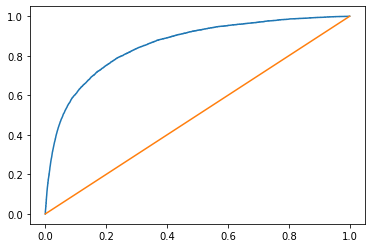

El AUC de la regresión logística es:  0.855226115733936
El accuracy de la regresión es:  0.9162666666666667
La precision de la regresión es:  0.39623750734861846
El recall de la regresión es:  0.47957876761064466
El puntaje F1 de la regresión es:  0.4339428277105331
El accuracy del árbol es:  0.9433428571428571
La precision del árbol es:  0.7240232751454697
El recall del árbol es:  0.24790095346520563
El puntaje F1 del árbol es:  0.3693416728506308


In [8]:
roc = clase_train.evaluacion()

En ambos modelos tenemos un muy buen accuracy, sobre todo el árbol, sin embargo dependiendo del objetivo de la clasificación se puede prestar más atención a una métrica más que la otra (recall y precision). 

#### Calculo del Mejor Umbral 

Con el siguiente código se hizo el calculo del mejor umbral, este es un poco demoroso debido al gran largo de la lista del ROC, es por esto que lo dejamos 
solo escrito. 

`Y = df_train.iloc[:,[0]]
f1_logit = []
for k in range(len(clase_train.roc_train[2])):
    umbral = clase_train.roc_train[2][k]
    preds_val = (clase_train.prediccion_logit_train >= umbral) * 1
    matriz_logit = metrics.confusion_matrix(Y, preds_val)
    tn, fp, fn, tp = matriz_logit.ravel()
    precision_logit = tp/(tp + fp)
    recall_logit = tp/(tp + fn)
    f1_logit.append( 2 * (precision_logit * recall_logit) / (precision_logit + recall_logit) )
f1_df = pd.DataFrame({'F1 Score': f1_logit})
f1_df.sort_values(by=['F1 Score'], ascending=False)
clase_train.roc_train[2][3807]
resultado del f1: 0.433943
resultado umbral: 0.184156`

#### Predicción

Para la predicción, con la misma clase definida se le hace el tratamiento de NA y las transformaciones a las variables.

In [9]:
ruta2 = '/Users/camilo/Google Drive/Universidad/Magíster en Estadística/2020-1/Minería de Datos con Python/Tareas/Tarea 2 2020/Entrega/Datos T-T/data_test.csv'
clase_test = Clasificador(ruta_datos = ruta2, porcentaje_na = 20)
df_test = clase_test.carga_de_datos()
clase_test.transformacion(max_bins = 10)

¿Desea transformar una variable? y/n: y


-------------------------------------------------------------


Ingrese el numero de columna que desea transformar (ej: 7): 1


-------------------------------------------------------------
Las transformaciones disponibles son las siguientes:
1: log(x)
2: raiz(x)
3: 1/x
4: x**(-2)


Ingrese el número de la transformación: 4


-------------------------------------------------------------


¿Desea transformar otra variable? y/n: y
Ingrese el numero de columna que desea transformar (ej: 7): 4


-------------------------------------------------------------
Las transformaciones disponibles son las siguientes:
1: log(x)
2: raiz(x)
3: 1/x
4: x**(-2)


Ingrese el número de la transformación: 3


-------------------------------------------------------------


¿Desea transformar otra variable? y/n: y
Ingrese el numero de columna que desea transformar (ej: 7): 5


-------------------------------------------------------------
Las transformaciones disponibles son las siguientes:
1: log(x)
2: raiz(x)
3: 1/x
4: x**(-2)


Ingrese el número de la transformación: 1


-------------------------------------------------------------


¿Desea transformar otra variable? y/n: n


-------------------------------------------------------------


¿Desea categorizar una variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 3


NumberOfTime3059DaysPastDueNotWorse
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2 y 3, elija una: 3


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 7


NumberOfTimes90DaysLate
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2, ingrese 2 si quiere categorizar:  2


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 8


NumberRealEstateLoansOrLines
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2, 3 y 4, elija una: 4


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 9


NumberOfTime6089DaysPastDueNotWorse
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2, ingrese 2 si quiere categorizar:  2


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: y
Ingrese el numero de columna que desea categorizar (ej: 3): 10


NumberOfDependents
Debido a la naturaleza de la variable el número de bins disponibles
para que cada categoría tenga 5% de los datos son: 


2, 3 y 4, elija una: 4


Éxito en la categorización.
-------------------------------------------------------------------


¿Desea categorizar otra variable? y/n: n


-------------------------------------------------------------
El proceso finalizó correctamente.


Notemos que `clase_test`se utilizó solo para el proceso de limpieza y transformación de los nuevos datos, sin embargo, utilizamos 
`clase_train`que es donde está nuestro modelo entrenado para predicir los nuevos datos.

In [10]:
diccionario_de_prediccion = clase_train.predecir(df_test)

Aquí tenemos el retorno de diccionario pedido, este consiste en las probabilidades del modelo logístico y sus predicciones (con el mejor umbral calculado en los pasos anteriores), además de las predicciones del árbol de decisión.

In [12]:
diccionario_de_prediccion

{'Probabilidades Predichas Logística': 0        0.012969
 1        0.017694
 2        0.038485
 3        0.104934
 4        0.035085
            ...   
 44995    0.029622
 44996    0.046240
 44997    0.014467
 44998    0.032746
 44999    0.094683
 Length: 45000, dtype: float64,
 'Predicción Logística': 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 44995    0
 44996    0
 44997    0
 44998    0
 44999    0
 Length: 45000, dtype: int64,
 'Predicción Árbol': array([0, 0, 0, ..., 0, 0, 0])}

#### Pickle

Utilizando la librería `pickle` guardamos nuestro objeto definido a través de la clase en un archivo en la raíz de nuestro proyecto, 
luego este archivo puede ser cargado en otra sesión de Python o en otro proyecto cargandose exactamente igual como fue guardado. Cabe destacar que no estamos guardando el código de definición de la clase, eso se puede hacer con otros métodos, por ejemplo, con modulos, lo que guardamos en este caso es el ajuste por lo que es necesario correr el código de la definición de la clase para luego cargar nuestra clase train con `pickle`. En resumen nos ahorramos re-entrenar el modelo cada vez que lo necesitemos usar. 

In [5]:
import pickle

Guardado de la Clase.

In [14]:
with open('modelo_ajustado.pickle', 'wb') as pickle_out:
    pickle.dump(clase_train, pickle_out)

Carga de la Clase

In [6]:
with open('modelo_ajustado.pickle', 'rb') as pickle_in:
    modelo_ajustado = pickle.load(pickle_in)

In [7]:
modelo_ajustado

Probamos viendo la base con que fue ajustado el modelo.

In [8]:
modelo_ajustado.base_de_datos.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime6089DaysPastDueNotWorse,NumberOfDependents
0,0,0.593805,63,"[0,1)",0.815189,7.824446,9,"[0,1)","[0,1)","[0,1)","[0,1)"
1,0,0.733202,53,"[0,1)",0.725487,8.404920,9,"[0,1)","[1,2)","[0,1)","[2,3)"
2,0,0.418090,67,"[2,98]",0.523486,8.294300,16,"[0,1)","[2,3)","[0,1)","[0,1)"
3,0,0.827384,45,"[0,1)",0.809328,9.066355,9,"[0,1)","[2,3)","[0,1)","[3,20]"
4,0,1.000000,31,"[0,1)",0.613705,8.140316,5,"[0,1)","[1,2)","[0,1)","[0,1)"


Prueba de nuestro ajuste de la regresión logística.

In [9]:
modelo_ajustado.logistica_fit

#### Conclusión General

##### Proceso

Dado como se realizó el procedimiento, este algoritmo se puede ejecutar una vez al mes sin problemas, pues gracias a la librería `pickle` el modelo queda ajustado y solo necesitamos hacer los siguientes pasos:

1. Obtener Nuevos datos
2. Tratamiento de NA (Automatizado, solo se tiene que ejecutar el método) 
3. Transformación de Variables (Automatizado en un método con preguntas simples al usuario)
4. Predecir con el método incorporado en la clase

##### Variables

De las variables categóricas las más importantes basandose en el Information Value son:

1. `NumberOfTime3059DaysPastDueNotWorse`
2. `NumberOfTimes90DaysLate`

De las variables numéricas las más importantes basandose en la Devianza (calculada con `statsmodels`):

1. `RevolvingUtilizationOfUnsecuredLines`
2. `Age`

Notemos que utilizar la devianza es válido pues todas las variables numéricas tienen 1 grado de libertad por lo que son comparables. 
Como comentario llama la atención que no ingrese al modelo `MonthlyIncome` por la relación directa con la economía personal o familiar de los individuos, por otro lado las variables categóricas señaladas tienen relación directa con el pago de deudas por lo que no sorprende su relevancia. En cuanto a las variables numéricas, tiene sentido que `RevolvingUtilizationOfUnsecuredLines` sea tan relevante porque es el porcentaje de cupo utilizado, esta puede indicar comportamientos financieros de cada individuo al igual que su edad, uno podría pensar que la gente jóven es más irresponsable financieramente. 

##### Ajuste 

* AUC de la regresión logística:  0.8552 
 * El AUC indica el área debajo de la Curva ROC, en general sobre 0.8 se considera bueno.  
<br/>


* Accuracy de la regresión es:  0.9163
 * Porcentaje de predicciones correctas, muy bueno. 
<br/>


* La precision de la regresión es:  0.3962
 * Aquí medimos que porcentajes de nuestros positivos que son realmente positivos, este indicador es bajo por la muestra desbalanceada.
<br/>


* El recall de la regresión es:  0.4796
 * Porcentaje de positivos correctos entre todos los verdaderos positivos, mejora comparando con la precisión pero aun así no es tan buena.
<br/>


* El accuracy del árbol es:  0.9433
 * Porcentaje de predicciones correctas, muy bueno.   
<br/>


* La precision del árbol es:  0.7240
 * Este indicador es considerablemente mayor que la regresión logística, muy bueno considerando el desbalance.  
<br/>


* El recall del árbol es:  0.2479
 * Este indicador es menor en este clasificador, por lo que el puntaje f1 no es muy distinto en ambos modelos.  


En ambos modelos se logró obtener un muy buen accuracy, especialmente en el árbol de decisión, sin embargo el porcentaje de la precición y el recall son menores en comparación. Esto no quiere decir que el modelo no sirva para nada, sin embargo hay tener presente los porcentajes en que falla y en que acierta para los costos y beneficios. Por otro lado nuestros datos estan desbalanceados y no aplicamos ninguna medida remedial como undersampling, oversampling o combinarlos con bootstrap por lo que nuestros indicadores podrían mejorar sustancialemente utilizando esas técnicas. Las últimas consideraciones son, el arbol se puede ajustar con más hojas y tiene un ajuste muy superior entre más profundidad pero no se traduce en los datos de testeo, en cambio la regresión logística obtiene resultados casi idénticos entre el entrenamiento y el testeo.